# CEBD1260: Full Machine Learning Pipeline
*by Hamza Benhmani & Pierre-Olivier Bonin*

> In this notebook, we use our custom function `utils.py` to aggregate, merge, and fill missing values of the Credit Risk datasets.
> Please look [here](https://github.com/gzork/the-big-short/blob/main/utils.py) for the function.

In [ ]:
import lightgbm as lgb
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import ntpath
import operator
import json
import re
from utils import *
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.metrics import roc_auc_score

data_dir = "../data/"

In [ ]:
with open("aggr_dicts.json") as json_file:
    data_from_json = json.load(json_file)
aggr_dicts = aggr_dicts_json_to_dict(data_from_json)
aggr_dicts

{'POS_CASH_balance': {'MONTHS_BALANCE': ['max',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'CNT_INSTALMENT': ['max', 'median'],
  'CNT_INSTALMENT_FUTURE': ['max', 'median']},
 'credit_card_balance': {'MONTHS_BALANCE': ['max', 'median'],
  'AMT_BALANCE': ['max', 'median'],
  'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'median'],
  'AMT_DRAWINGS_ATM_CURRENT': ['max', 'median'],
  'AMT_DRAWINGS_CURRENT': ['max', 'median'],
  'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'median'],
  'AMT_DRAWINGS_POS_CURRENT': ['max', 'median'],
  'AMT_INST_MIN_REGULARITY': ['max', 'median'],
  'AMT_PAYMENT_CURRENT': ['max', 'median'],
  'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'median'],
  'AMT_RECEIVABLE_PRINCIPAL': ['max', 'median'],
  'AMT_RECIVABLE': ['max', 'median'],
  'AMT_TOTAL_RECEIVABLE': ['max', 'median'],
  'CNT_DRAWINGS_ATM_CURRENT': ['max', 'median'],
  'CNT_DRAWINGS_CURRENT': ['max', 'median'],
  'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'median'],
  'CNT_DRAWINGS_POS_CURRENT

In [ ]:
%%time
names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

dfs["application_train"].shape

CPU times: user 31.5 s, sys: 3.59 s, total: 35.1 s
Wall time: 35.1 s


(307511, 122)

In [ ]:
def train_model():
    # main_df = preprocessing_data() we remove this since we've already done the preprocessing
    # building model
    model_lgb = lgb.LGBMClassifier(
        n_jobs=6,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.01,
        num_leaves=64,
        num_threads=4,
        max_depth=-1,
        tree_learner="serial",
        feature_fraction=0.7,
        bagging_freq=5,
        bagging_fraction=0.7,
        min_data_in_leaf=100,
        silent=-1,
        verbose=-1,
        max_bin=255,
        bagging_seed=11,
    )

    features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
    X = main_df[features]
    y = main_df['TARGET']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)

    model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc', verbose=200,
                  early_stopping_rounds=300)
    y_valid_lgb = model_lgb.predict_proba(X_valid, num_iteration=model_lgb.best_iteration_)[:, 1]

## Benchmark Model: performance is 76.3% correct prediction on 1s

In [ ]:
main_df = dfs['application_train']
na_catfiller(main_df)
na_numfiller(main_df)
main_df = str_catencoder(main_df)

train_model()

[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.756664	training's binary_logloss: 0.272206	valid_1's auc: 0.744845	valid_1's binary_logloss: 0.275158
[400]	training's auc: 0.772295	training's binary_logloss: 0.244296	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.250647
[600]	training's auc: 0.78898	training's binary_logloss: 0.237393	valid_1's auc: 0.757569	valid_1's binary_logloss:

## Aggregations and Merging

In [ ]:
%%time
bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
bureau_balance.reset_index(level=0, inplace=True)
bureau_balance

CPU times: user 2min 25s, sys: 1.47 s, total: 2min 26s
Wall time: 2min 26s


,SK_ID_BUREAU,STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF
0,5001709,NaN,NaN,NaN,NaN,NaN,NaN,85.0,10.0
1,5001710,5.0,NaN,NaN,NaN,NaN,NaN,47.0,33.0
2,5001711,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,5001712,9.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN
4,5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...,...
817390,6842884,8.0,NaN,NaN,NaN,NaN,NaN,19.0,27.0
817391,6842885,11.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN
817392,6842886,7.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN
817393,6842887,5.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN


In [ ]:
%%time
dfs["bureau"] = dfs["bureau"].merge(bureau_balance,on='SK_ID_BUREAU',how='left')
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

CPU times: user 1.37 s, sys: 224 ms, total: 1.6 s
Wall time: 1.6 s


In [ ]:
%%time

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

main_df.shape, main_df.columns.tolist()

CPU times: user 46.9 s, sys: 1.34 s, total: 48.2 s
Wall time: 48.2 s


((307511, 253),
 ['SK_ID_CURR',
  'TARGET',
  'NAME_CONTRACT_TYPE',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'NAME_TYPE_SUITE',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'OCCUPATION_TYPE',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'WEEKDAY_APPR_PROCESS_START',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'APAR

In [ ]:
main_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,8.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
main_df.isnull().sum().sum()/216

74830.4074074074

In [ ]:
na_numfiller(main_df, aggregation_func="median")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,6.0,6.0,12.0,1.0,8.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,6.0,6.0,18.0,18.0,23.0,23.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,6.0,6.0,28.0,28.0,13.0,4.5


In [ ]:
main_df.isnull().sum().sum()

0

In [ ]:
na_catfiller(main_df)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_merged_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,6.0,6.0,12.0,1.0,8.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,6.0,6.0,31.0,19.0,13.0,4.5
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,6.0,6.0,18.0,18.0,23.0,23.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,6.0,6.0,28.0,28.0,13.0,4.5


In [ ]:
main_df.isnull().sum().sum()

0

In [ ]:
optimize_inttypes(main_df, specify="int32")

Memory usage of dataframe is 0.624862 GB
Total initial memory used for selected dataframe is: 0.62GB
Memory usage of dataframe is 0.574431 GB
Total memory currently used for selected dataframe is: 0.57GB


In [ ]:
optimize_floattypes(main_df, specify="float32")

Memory usage of dataframe is 0.574431 GB
Total initial memory used for selected dataframe is: 0.57GB
Memory usage of dataframe is 0.333342 GB
Total memory currently used for selected dataframe is: 0.33GB


In [ ]:
main_df.shape

(307511, 253)

In [ ]:
main_df = str_catencoder(main_df)

In [ ]:
main_df.shape

(307511, 308)

In [ ]:
main_df.isnull().sum().sum()

0

In [ ]:
main_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_missing_data,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_missing_data
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,1,0,0,1,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,1,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,1,0,0,1
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,1,0,0,1
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,1,0,0,1


# Train-Test Split and Modelling using LightGBM

In [ ]:
train_model()

[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.766729	training's binary_logloss: 0.270307	valid_1's auc: 0.748048	valid_1's binary_logloss: 0.274398
[400]	training's auc: 0.789055	training's binary_logloss: 0.239439	valid_1's auc: 0.759079	valid_1's binary_logloss: 0.248427
[600]	training's auc: 0.811334	training's binary_logloss: 0.229751	valid_1's auc: 0.769436	valid_1's binary_logloss

> Now we need to do more feature engineering to try to improve our model. I have targeted a few columns that are not currently in use and could be added:

    In previous_application:
    * NAME_CASH_LOAN_PURPOSE
    * NAME_CONTRACT_STATUS
    * CODE_REJECT_REASON
    * ... basically all of the potentially useful categorical features.


In [ ]:
main_df.shape, main_df.isnull().sum().sum()

((307511, 308), 0)

### Try again, using a different threshold for the categorical features encoding (method_switch=50)

In [ ]:
%%time

names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

dfs["application_train"].shape

bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
bureau_balance.reset_index(level=0, inplace=True)

dfs["bureau"] = dfs["bureau"].merge(bureau_balance,on='SK_ID_BUREAU',how='left')
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

na_numfiller(main_df, aggregation_func="median")
optimize_inttypes(main_df, specify="int32")
optimize_floattypes(main_df, specify="float32")
main_df = str_catencoder(main_df, method_switch=50)

Memory usage of dataframe is 0.624862 GB
Total initial memory used for selected dataframe is: 0.62GB
Memory usage of dataframe is 0.574431 GB
Total memory currently used for selected dataframe is: 0.57GB
Memory usage of dataframe is 0.574431 GB
Total initial memory used for selected dataframe is: 0.57GB
Memory usage of dataframe is 0.333342 GB
Total memory currently used for selected dataframe is: 0.33GB
CPU times: user 4min 11s, sys: 17.4 s, total: 4min 29s
Wall time: 4min 29s


In [ ]:
main_df.shape

(307511, 320)

In [ ]:
train_model()

[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.766506	training's binary_logloss: 0.270381	valid_1's auc: 0.748133	valid_1's binary_logloss: 0.274409
[400]	training's auc: 0.78977	training's binary_logloss: 0.23948	valid_1's auc: 0.760474	valid_1's binary_logloss: 0.248243
[600]	training's auc: 0.811558	training's binary_logloss: 0.229806	valid_1's auc: 0.770579	valid_1's binary_logloss: 

> This is actually worse than the previous version using `str_catencoder(main_df, method_switch=10)`. Let's try more feature engineering.

# KFold cross-validation & Feature Importance

In [ ]:
# get X and y, X input, y target: this is total data set X and y
features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
X = main_df[features]
y = main_df['TARGET']

#split out for some test set as if it is future unseen data, using train_test_split for now
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)
print(X_train.shape,X_test.shape,len(y_train),len(y_test))

# we reindex the objects
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

#define your lightgbm model by initializing parameters
model_lgb = lgb.LGBMClassifier(
            n_jobs=4,
            n_estimators=100000,
            boost_from_average='false',
            learning_rate=0.01,
            num_leaves=64,
            num_threads=4,
            max_depth=-1,
            tree_learner = "serial",
            feature_fraction = 0.7,
            bagging_freq = 5,
            bagging_fraction = 0.7,
            min_data_in_leaf=100,
            silent=-1,
            verbose=-1,
            max_bin = 255,
            bagging_seed = 11,
            )

#initialize KFold, we can use stratified KFold to keep the same imbalance ratio for target
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

# Use KFold to train 5 models
auc_scores = [] # save auc score for each fold
models = [] #save model for each fold
for i, (train_idx,valid_idx) in enumerate(kf.split(X_train,y_train)):
    
    print('...... training {}th fold \n'.format(i+1))
    tr_X = X_train.loc[train_idx]
    tr_y = y_train.loc[train_idx]
    
    va_X = X_train.loc[valid_idx]
    va_y = y_train.loc[valid_idx]
    
    model = model_lgb # you need to initialize your lgb model at each loop, otherwise it will overwrite
    model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (va_X, va_y)], eval_metric = 'auc', verbose=500, early_stopping_rounds = 300)
    
    # calculate current auc after training the model
    pred_va_y = model.predict_proba(va_X,num_iteration=model.best_iteration_)[:,1]
    auc = roc_auc_score(va_y,pred_va_y)
    print('current best auc score is:{}'.format(auc))
    auc_scores.append(auc)
    models.append(model)

(276759, 318) (30752, 318) 276759 30752
...... training 1th fold 

[LightGBM] [Warning] num_threads is set=4, n_jobs=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.80797	training's binary_logloss: 0.23199	valid_1's auc: 0.770572	valid_1's binary_logloss: 0.243658
[1000]	training's auc: 0.856186	training's binary_logloss: 0.212639	valid_1's auc: 0.781535	valid_1's binary_logloss: 0.238934
[1500]	training's auc: 0.891416	training's binary

## Evaluate the models

In [ ]:
print('the average mean auc is:{}'.format(np.mean(auc_scores)))

pred_test_1 = models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]
pred_test_2 = models[1].predict_proba(X_test,num_iteration=models[1].best_iteration_)[:,1]
pred_test_3 = models[2].predict_proba(X_test,num_iteration=models[2].best_iteration_)[:,1]
pred_test_4 = models[3].predict_proba(X_test,num_iteration=models[3].best_iteration_)[:,1]
pred_test_5 = models[4].predict_proba(X_test,num_iteration=models[4].best_iteration_)[:,1]

pred_test = (pred_test_1+pred_test_2+pred_test_3+pred_test_4+pred_test_5)/5.0

models[0].predict(X_test,num_iteration=models[0].best_iteration_)

models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]

the average mean auc is:0.7824284119342167


array([0.04733656, 0.04692937, 0.16341439, ..., 0.03153319, 0.02531029,
       0.03140894])

In [ ]:
fts = X_train.columns.values # all features currently used
fts

array(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTME

In [ ]:
fts_imp = dict(zip(fts,models[2].feature_importances_))
fts_imp = sorted(fts_imp.items(), key=operator.itemgetter(1),reverse=True)
fts_imp[:20]

[('EXT_SOURCE_2', 3611),
 ('EXT_SOURCE_3', 3406),
 ('EXT_SOURCE_1', 3237),
 ('DAYS_BIRTH', 3109),
 ('AMT_ANNUITY', 2916),
 ('DAYS_ID_PUBLISH', 2513),
 ('AMT_CREDIT', 2479),
 ('DAYS_REGISTRATION', 2385),
 ('DAYS_EMPLOYED', 2338),
 ('bureau_merged_DAYS_CREDIT_max', 2241),
 ('AMT_GOODS_PRICE', 2080),
 ('bureau_merged_DAYS_CREDIT_ENDDATE_max', 2058),
 ('DAYS_LAST_PHONE_CHANGE', 2011),
 ('bureau_merged_AMT_CREDIT_SUM_max', 1959),
 ('bureau_merged_AMT_CREDIT_SUM_median', 1925),
 ('POS_CASH_balance_MONTHS_BALANCE_max_min_diff', 1884),
 ('previous_application_SELLERPLACE_AREA_max', 1841),
 ('installments_payments_AMT_PAYMENT_median', 1833),
 ('bureau_merged_DAYS_CREDIT_ENDDATE_median', 1759),
 ('bureau_merged_DAYS_CREDIT_UPDATE_median', 1744)]

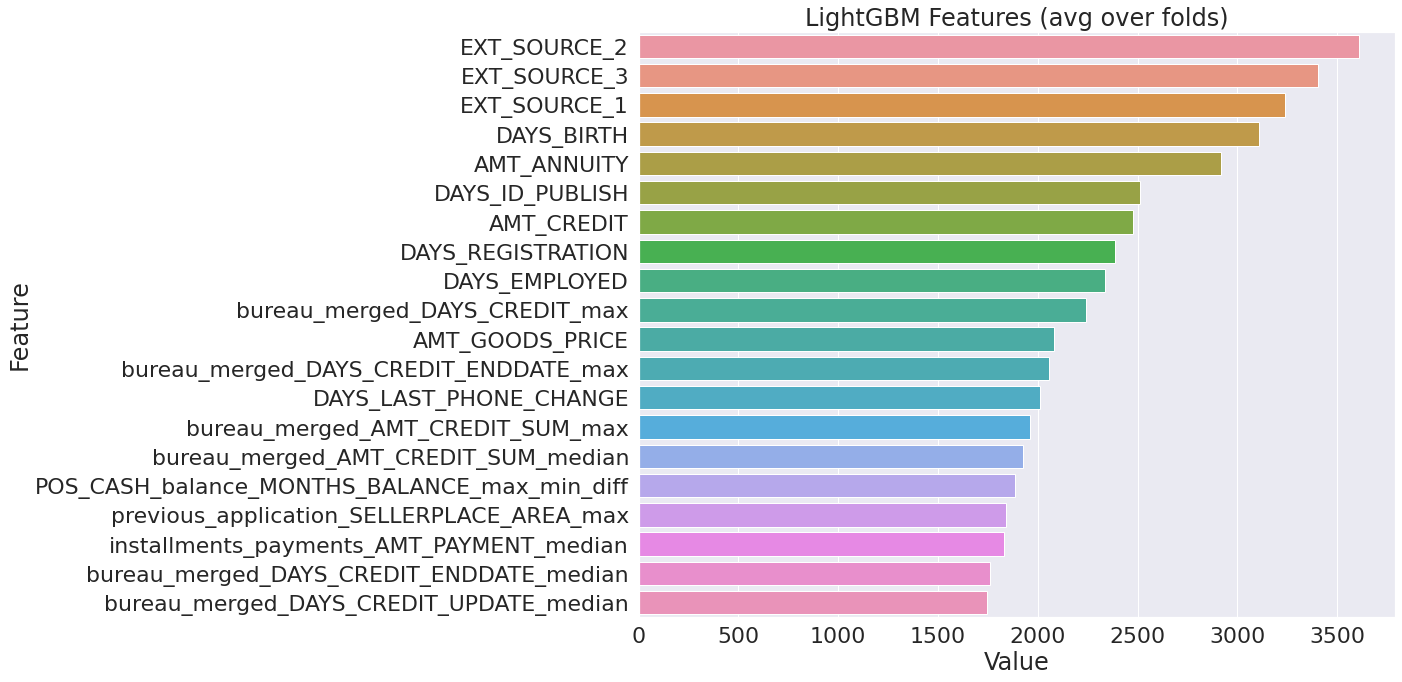

In [ ]:
#print feature importance
feature_imp = pd.DataFrame({'Value':models[0].feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')
plt.show()